# MLDL2 Homework 3

전체 학습 과정은 아래와 같습니다.
1. WideResNet을 CIFAR-100으로 pretrain
2. pretrain한 모델을 CUB-200으로 Fine-Tuning
  * a. CUB-200을 저해상도로 낮춘 데이터(128*128)를 학습
  * b. CUB-200(224*224)를 학습

본 파일에는 2.b.에 대한 코드와 최종 성능을 확인하는 코드가 포함되어 있으며, 1과 2.a에 대한 코드와 모델 파일(.pt)는 아래 Github 링크 참고 부탁드립니다.

In [2]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torchvision import datasets
import torch.nn.functional as F
from tqdm.auto import tqdm
from PIL import Image

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/DL2-HW3/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1qkSIvHiyObWh2Td5y1PDSfWTFnztRWC1/DL2-HW3


# 2. Load the Caltech UCSD Birds-200 Dataset

In [13]:
BATCH_SIZE = 32

class CUB_Dataset(Dataset):
    def __init__(self,img_file, label_file, transform=None):
        self.img =np.load(img_file)
        self.labels = np.load(label_file)
        self.transform = transform

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        image = self.img[idx]
        label = self.labels[idx]

        if image.max() <= 1.0:
            image = (image * 255).astype('uint8')

        # NumPy 배열을 PIL 이미지로 변환
        image = Image.fromarray(image)


        if self.transform:
            image = self.transform(image)


        return image,label

cub_bird_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

### transform for train data
cub_bird_transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [14]:
cub_train_dataset = CUB_Dataset(img_file="./data/CUB_train_images.npy",
                                        # label_file="./data/CUB_train_labels.npy",transform=cub_bird_transform_train) ### transform for training data (128*128)
cub_finetune_dataset = CUB_Dataset(img_file="./data/CUB_train_images.npy",
                                        label_file="./data/CUB_train_labels.npy",transform=cub_bird_transform) ### transform for finetuning data (224*224)

cub_train_loader = torch.utils.data.DataLoader(cub_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

cub_finetune_loader = torch.utils.data.DataLoader(cub_finetune_dataset, batch_size=BATCH_SIZE, shuffle=True)

cub_val_dataset = CUB_Dataset(img_file="./data/CUB_val_images.npy",
                                        label_file="./data/CUB_val_labels.npy",transform=cub_bird_transform)
cub_val_loader = torch.utils.data.DataLoader(cub_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [15]:
# Number of samples in the dataset
# print("caltech bird train dataset size : ", len(cub_train_dataset))
print("caltech bird finetune dataset size : ", len(cub_finetune_dataset))
print("caltech bird validation dataset size : ", len(cub_val_dataset))

caltech bird finetune dataset size :  5994
caltech bird validation dataset size :  2897


## Caltech UCSD Birds-200 Visualiztion

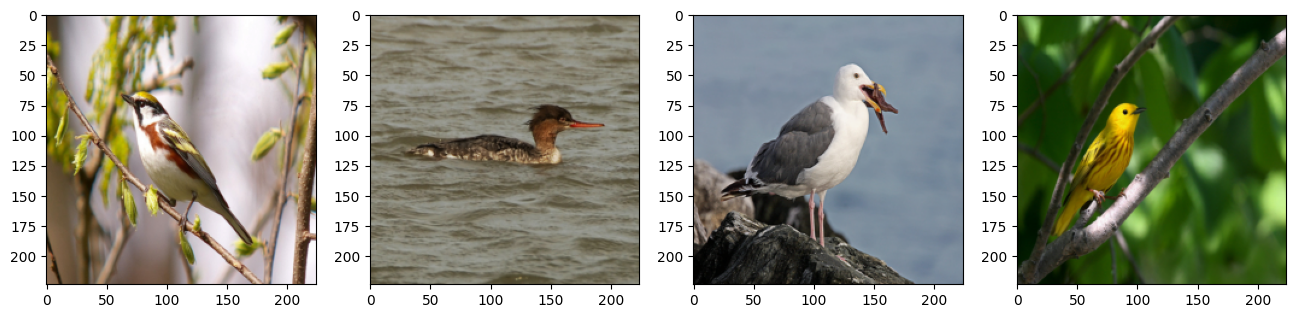

tensor([164,  89,  65, 181])


In [ ]:
# Plot the training images and labels

cub_denormalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])
to_pil_image = transforms.functional.to_pil_image

# images, labels = next(iter(cub_train_loader))
images, labels = next(iter(cub_finetune_loader))
images, labels = next(iter(cub_val_loader))

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].imshow(to_pil_image(cub_denormalize(images[0])))
ax[1].imshow(to_pil_image(cub_denormalize(images[1])))
ax[2].imshow(to_pil_image(cub_denormalize(images[2])))
ax[3].imshow(to_pil_image(cub_denormalize(images[3])))
plt.show()

print(labels[:4])

# 3. Define the Model Architecture

Here we define the model. Below is very simple model with CNN. You can customize your own model and note that you are not limited to use any methods. **But you are not allowed to use pretrained weight**

In [11]:
# low frequency로 finetuning한 모델(model_train_cub_epoch30.pt)을 불러옴

from collections import OrderedDict
import torch
import importlib

# 기존 config
pretrain_config = OrderedDict([
    ('arch', 'wrn'),  # Wide ResNet
    ('depth', 28),
    ('base_channels', 16),
    ('widening_factor', 10),
    ('drop_rate', 0.3),
    ('input_shape', (1, 3, 128, 128)),
    ('n_classes', 200),
])



def load_model(config):
    module = importlib.import_module(config['arch'])
    Network = getattr(module, 'Network')
    return Network(config)

# 모델 초기화
model = load_model(pretrain_config)

# Pretrained weights 로드
checkpoint = torch.load("model_train_cub_epoch30.pt")
print(f"checkpoint.keys(): {checkpoint.keys()}")
model.load_state_dict(checkpoint['state_dict'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

<ipython-input-11-62cc4cb0234c>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model_train_cub_epoch30.pt")


checkpoint.keys(): odict_keys(['state_dict', 'optimizer', 'epoch'])


In [16]:
# low frequency로 finetuning한 모델의 성능을 val set 확인
correct = 0
total = 0

with torch.no_grad():
    for data in cub_val_loader:
        images, labels = data
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()

print(f'Finetune 이전) Accuracy of the network on the 2897 validation images: {100 * correct / total:.2f} %')

Finetune 이전) Accuracy of the network on the 2897 validation images: 24.16 %


In [ ]:
def efdm_loss(content_features, style_features):
    """
    EFDM loss function to match the feature distributions.
    Arguments:
    - content_features: Features extracted from the current batch
    - style_features: Target features to match

    Returns:
    - Loss value (float)
    """
    # Sort features
    _, index_content = torch.sort(content_features.view(content_features.size(0), -1), dim=1)
    value_style, _ = torch.sort(style_features.view(style_features.size(0), -1), dim=1)
    inverse_index = index_content.argsort(dim=1)

    # Perform Sort-Matching for EFDM
    matched_features = (
        content_features.view(content_features.size(0), -1)
        + value_style.gather(1, inverse_index)
        - content_features.view(content_features.size(0), -1).detach()
    )

    # Compute mean squared error (MSE) loss between matched features
    loss = torch.mean((content_features.view(content_features.size(0), -1) - matched_features) ** 2)
    return loss

MIX UP

In [17]:

"""MIX UP"""

def mixup(inputs, targets, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    batch_size = inputs.size(0)
    index = torch.randperm(batch_size).to(inputs.device)

    mixed_inputs = lam * inputs + (1 - lam) * inputs[index, :]
    labels_a, labels_b = targets, targets[index]
    return mixed_inputs, labels_a, labels_b, lam

def MixUpLoss(criterion, pred, labels_a, labels_b, lam):
    return lam * criterion(pred, labels_a) + (1 - lam) * criterion(pred, labels_b)

In [18]:
def train_mixup(model, epochs, train_loader, criterion, optimizer, device, scheduler=None):
    print("Mixup Training started!")

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        for i, data in enumerate(tqdm(train_loader)):
            inputs, targets = data[0].to(device), data[1].to(device)

            # Apply mixup augmentation
            mixed_inputs, labels_a, labels_b, lam = mixup(inputs, targets)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(mixed_inputs)
            loss = MixUpLoss(criterion, outputs, labels_a, labels_b, lam)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Accumulate running loss
            running_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct += lam * predicted.eq(labels_a).sum().item() + (1 - lam) * predicted.eq(labels_b).sum().item()
            total += targets.size(0)

        # Calculate epoch statistics
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

        if (epoch+1)%5==0:
            state = OrderedDict([
                ('state_dict', model.state_dict()),
                ('optimizer', optimizer.state_dict()),
                # ('scheduler', scheduler.state_dict()),
                ('epoch', epoch)
            ])
            torch.save(state, f"./model_finetune_cub_epoch{epoch+1}.pt")

        # Update learning rate if a scheduler is provided
        if scheduler:
            scheduler.step()

    print("Training complete!")

# 4. Train the network

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4) # you can use any other optimizer

print('start training with high resolution')
train_mixup(model, epochs=20, train_loader=cub_finetune_loader, criterion=criterion, optimizer=optimizer, device=device)

start training with high resolution
Mixup Training started!


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1/20, Loss: 3.9549, Accuracy: 0.1834


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2/20, Loss: 3.4860, Accuracy: 0.2821


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 3/20, Loss: 3.2685, Accuracy: 0.3456


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 4/20, Loss: 3.1133, Accuracy: 0.3728


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 5/20, Loss: 3.0344, Accuracy: 0.4018


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 6/20, Loss: 3.0112, Accuracy: 0.4124


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 7/20, Loss: 2.8808, Accuracy: 0.4445


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 8/20, Loss: 2.8372, Accuracy: 0.4581


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 9/20, Loss: 2.7461, Accuracy: 0.4886


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 10/20, Loss: 2.6216, Accuracy: 0.5090


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 11/20, Loss: 2.6522, Accuracy: 0.4971


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 12/20, Loss: 2.5833, Accuracy: 0.5143


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 13/20, Loss: 2.5477, Accuracy: 0.5234


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 14/20, Loss: 2.4444, Accuracy: 0.5638


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 15/20, Loss: 2.4401, Accuracy: 0.5613


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 16/20, Loss: 2.3977, Accuracy: 0.5632


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 17/20, Loss: 2.3757, Accuracy: 0.5671


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 18/20, Loss: 2.2867, Accuracy: 0.5864


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 19/20, Loss: 2.2175, Accuracy: 0.6026


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 20/20, Loss: 2.2851, Accuracy: 0.5960
Training complete!


In [21]:
### eval with validation set
correct = 0
total = 0
with torch.no_grad():
    for data in cub_val_loader:
        images, labels = data
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()

print(f'high freq 학습 이후) Accuracy of the network on the 2897 validation images: {100 * correct / total:.2f} %')

high freq 학습 이후) Accuracy of the network on the 2897 validation images: 59.82 %


In [22]:
# 추가 epoch 10 학습
train_mixup(model, epochs=10, train_loader=cub_finetune_loader, criterion=criterion, optimizer=optimizer, device=device)

correct = 0
total = 0
with torch.no_grad():
    for data in cub_val_loader:
        images, labels = data
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()

print(f'high freq 학습 이후) Accuracy of the network on the 2897 validation images: {100 * correct / total:.2f} %')

Mixup Training started!


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1/10, Loss: 2.2206, Accuracy: 0.6039


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2/10, Loss: 2.1311, Accuracy: 0.6397


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.1843, Accuracy: 0.6106


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.1108, Accuracy: 0.6309


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.0406, Accuracy: 0.6563


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.0412, Accuracy: 0.6473


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.0452, Accuracy: 0.6436


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 8/10, Loss: 1.9552, Accuracy: 0.6638


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.0734, Accuracy: 0.6379


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 10/10, Loss: 1.9093, Accuracy: 0.6802
Training complete!
high freq 학습 이후) Accuracy of the network on the 2897 validation images: 66.14 %


# 5. Evaluate the network on the validation data

In [23]:
correct = 0
total = 0

### train
with torch.no_grad():
    for data in cub_val_loader:
        images, labels = data
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()

print(f'Accuracy of the network on the 2897 validation images: {100 * correct / total:.2f} %')

Accuracy of the network on the 2897 validation images: 66.90 %


# 6. Test and Submit

You can modify your TestDataset, but you should be mindful to align it with the training dataset and its transformations.

In [24]:
class TestDataset(Dataset):
    def __init__(self, img_file, transform=None):
        self.img =np.load(img_file)
        self.transform = transform

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        image = self.img[idx]
        if self.transform is not None:
            image = self.transform(image)

        return image

test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_dataset = TestDataset(img_file="./data/CUB_test_images.npy",transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

## **Do not modify the cell below!!!!**


In [25]:
def test(model, test_loader):
  model.eval()
  test_predictions = []

  with torch.inference_mode():
      for i, data in enumerate(tqdm(test_loader)):
          data = data.float().to(device)
          output = model(data)
          test_predictions.append(output.cpu())

  return torch.cat(test_predictions, dim=0)

In [26]:
# Save test output npy file
predictions = test(model, test_loader)
np.save('./Test_results', predictions.numpy())

  0%|          | 0/91 [00:00<?, ?it/s]